In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

In [99]:
with open('results/2019-11-02_11-00-12_smooth_monotonic/smooth_monotonic_modeling_result.pkl', 'rb') as handle:
    x = pickle.load(handle)

In [100]:
x
x_subsample = x.final.b_nn_corrected[::50][300:]
time_subsample = x.base_signals.t_b_nn[::50][300:]
time_subsample = time_subsample.reshape(-1,1)

In [68]:
x_subsample.size

482

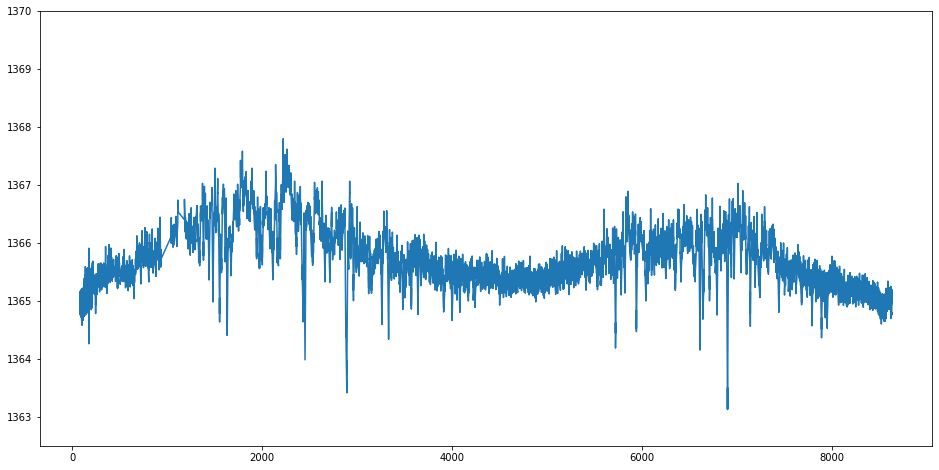

In [69]:
plt.figure(5, figsize=(16, 8))
plt.ylim(1362.5, 1370)
plt.plot(x.base_signals.t_b_nn, x.final.b_nn_corrected)

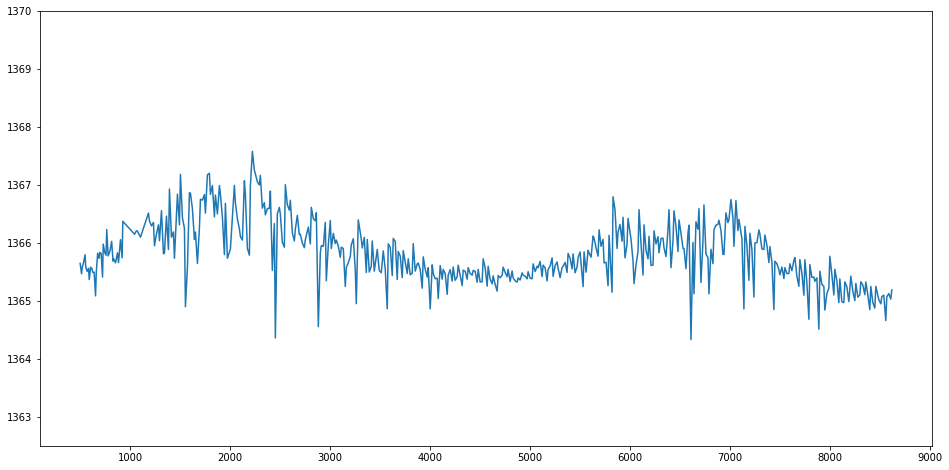

In [70]:
plt.figure(5, figsize=(16, 8))
plt.ylim(1362.5, 1370)
plt.plot(time_subsample, x_subsample)

In [71]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic, ExpSineSquared, ConstantKernel

In [72]:
kernel = ConstantKernel() * (WhiteKernel() + RationalQuadratic() + ExpSineSquared())

In [73]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(time_subsample, x_subsample)

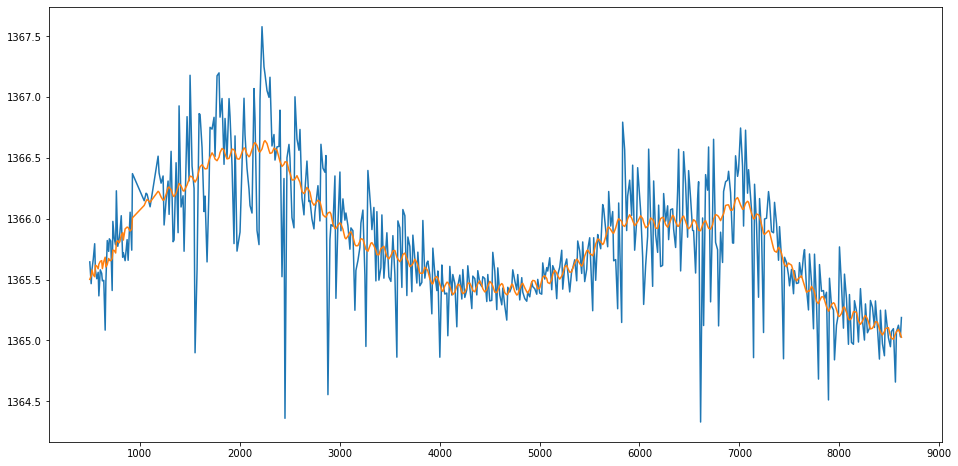

In [74]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_subsample, x_subsample, time_subsample, gpr.predict(time_subsample))

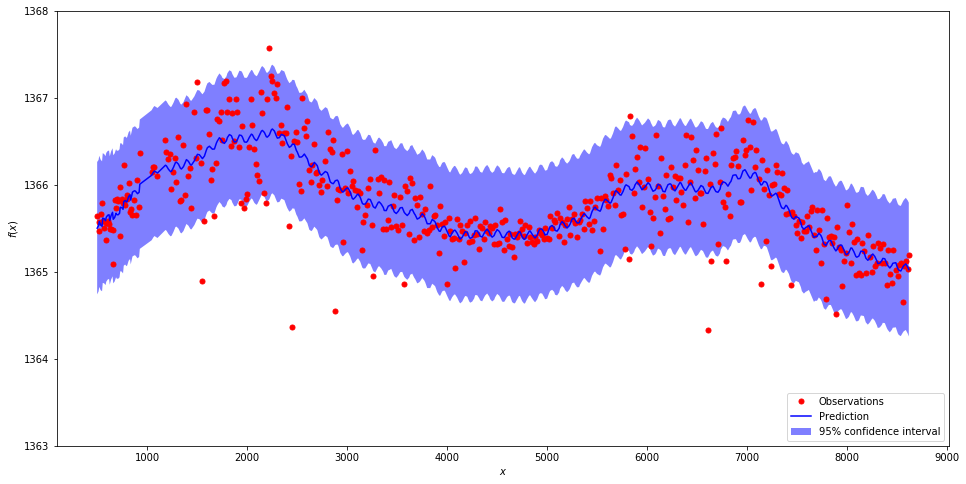

In [98]:
X = time_subsample
y = x_subsample
y_pred, sigma = gpr.predict(time_subsample, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(time_subsample, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([time_subsample, time_subsample[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(1363, 1368)
#plt.xlim(2000, 4000)
plt.legend(loc='lower right')

# Fourier tranform

In [165]:
S = np.abs(np.fft.fft(x_subsample - np.mean(x_subsample)))
x_filtered = np.fft.fft(x_subsample - np.mean(x_subsample)).copy()
x_filtered[S<50] = 0
x_filtered = np.fft.ifft(x_filtered)

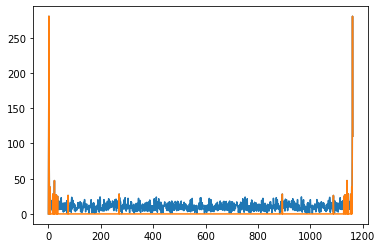

In [166]:
plt.plot(np.abs(np.fft.fft(x_subsample - np.mean(x_subsample))))
plt.plot(S_filtered)

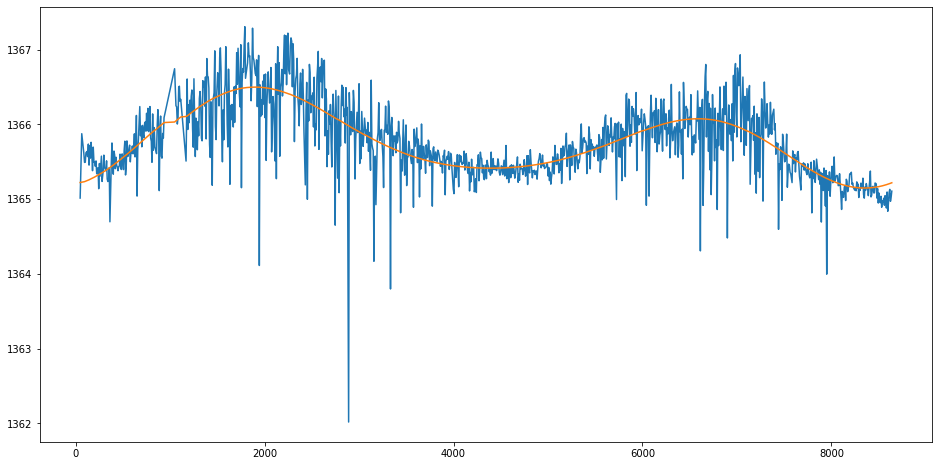

In [167]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_subsample, x_subsample, time_subsample, x_filtered + np.mean(x_subsample))

# Kalman filter

In [248]:
from pykalman import KalmanFilter
from scipy.interpolate import interp1d

In [249]:
signal_a, sihnal_b = x.final.a_nn_corrected, x.final.b_nn_corrected
time_a, time_b = x.base_signals.t_a_nn, x.base_signals.t_b_nn
mean_signal = np.mean(np.concatenate((signal_a, signal_b), axis=0))
a, b = interp1d(time_a, signal_a), interp1d(time_b, signal_b )

In [250]:
time_interval = (max(time_a[0], time_b[0]), min(time_a[-1], time_b[-1]))
time_sample = np.linspace(time_interval[0], time_interval[1], 500)

In [251]:
a_sample = a(time_sample)
b_sample = b(time_sample)

In [252]:
data = np.stack((a_sample, b_sample), axis=1)

In [253]:
data.shape

(500, 2)

In [254]:
kf = KalmanFilter(n_dim_obs=2,
                  initial_state_mean = 0,
                  transition_matrices = [[1]],
                  transition_offsets = 0,
                  observation_matrices = [[1],[1]],
                  observation_offsets = [0,0],
                  em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance'])
kf.em(data)

(-3, 3)

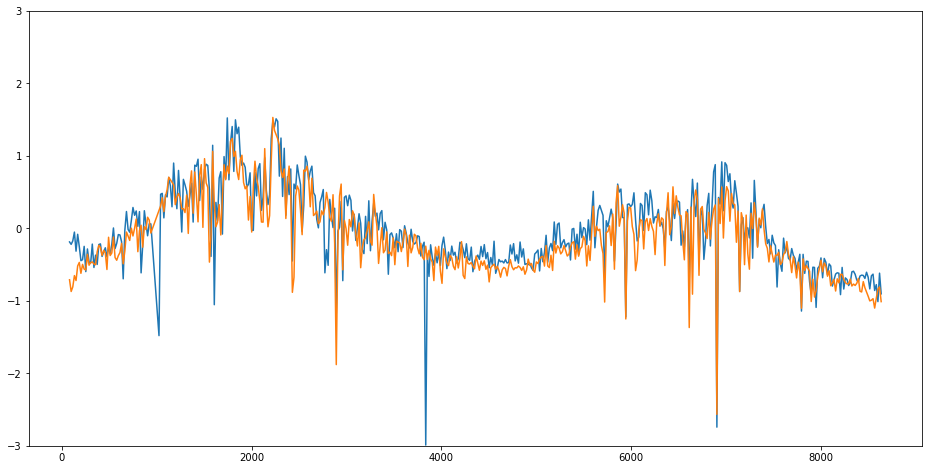

In [255]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_sample, a_sample, time_sample, b_sample)
plt.ylim(-3, 3)

In [256]:
x_smoothed_mean, x_smoothed_covariance = kf.smooth(data)

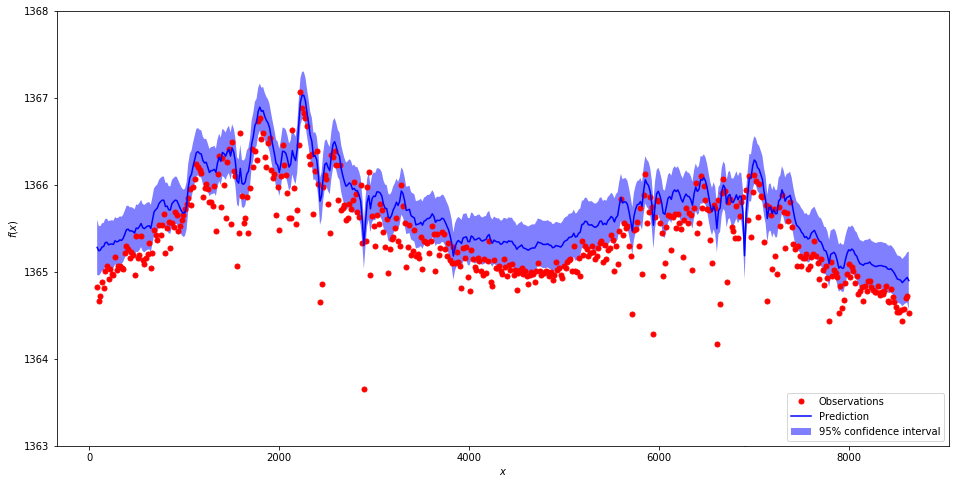

In [257]:
X = time_sample
#y = x_subsample
y_pred, sigma = x_smoothed_mean.ravel() + np.mean(mean_signal), np.sqrt(x_smoothed_covariance.ravel())

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(5, figsize=(16, 8))
#plt.plot(time_sample, a_sample + np.mean(signal_a), 'r.', markersize=10, label='Observations')
plt.plot(time_sample, b_sample + np.mean(signal_b), 'r.', markersize=10, label='Observations')
#plt.plot(time_a, signal_a)
plt.plot(time_sample, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([time_sample, time_sample[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(1363, 1368)
plt.legend(loc='lower right')

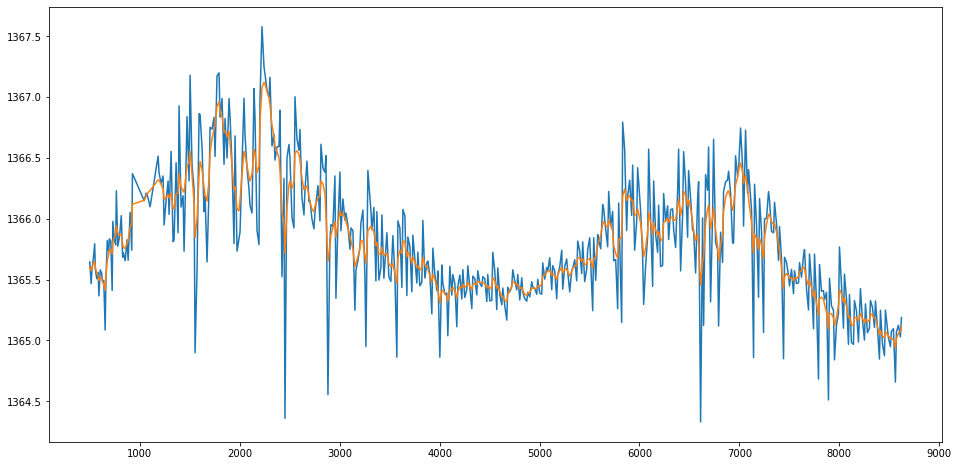

In [86]:
plt.figure(5, figsize=(16, 8))
plt.plot(time_subsample, x_subsample, time_subsample, x_smoothed + np.mean(x_subsample))